## Supervised Learning
## Project: Finding Donors for *CharityML*

In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import matplotlib.pyplot as plt
import seaborn as sns
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Constants
#RAND_STATE = 7 #(It could be a number other than 1 ..,and could be assigned in each line code, ) 
BETA = 0.5

# Load the Census dataset
data = pd.read_csv("census.csv")

# Displaing the first three records
display(data.head(n=3))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [4]:
# Getting the last 3 records just to look at the end of the data. 
display(data.tail(n=3))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
45219,38,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
45220,44,Private,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K
45221,35,Self-emp-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K


In [5]:
# Getting the number of rows
print("number of rows : ", data.shape[0])
# Getting the number of columns
print("number of columns : ", data.shape[1])

number of rows :  45222
number of columns :  14


In [6]:
# Exploring the data information to know features datatype, and to detect that there is no missing records.  
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


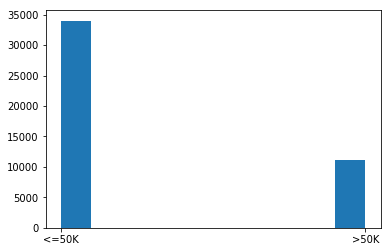

In [5]:
# Exploring a simple disterbution of target coulmn: "income" from the dataset:data
plt.hist(data["income"]);

In [7]:
# Exploring the non_numerical features values (categorical variables values) 
# May be that is useful to know about removing ill-formatted entries in non_numerical features.

for featureName, featureValues in data.iteritems():
    if(featureValues.dtype != np.float64 and featureValues.dtype != np.int64):
        print('{featureName}: {featureValues}\n'.format(featureName=featureName, featureValues=featureValues.unique())) 

workclass: [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' Self-emp-inc' ' Without-pay']

education_level: [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' 7th-8th' ' Doctorate' ' Assoc-voc' ' Prof-school'
 ' 5th-6th' ' 10th' ' Preschool' ' 12th' ' 1st-4th']

marital-status: [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']

occupation: [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Transport-moving' ' Farming-fishing'
 ' Machine-op-inspct' ' Tech-support' ' Craft-repair' ' Protective-serv'
 ' Armed-Forces' ' Priv-house-serv']

relationship: [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']

race: [' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']

sex: [' Male' ' Female']

native-country: [' United-States' ' Cuba' ' Jamaica' ' India' ' Mexi

In [8]:
# Exploring the summary statistical description of numerical features values (Continuous variables values)
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [9]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data["income"] == ">50K"])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data["income"] == "<=50K"])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = round(n_greater_50k / n_records * 100, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

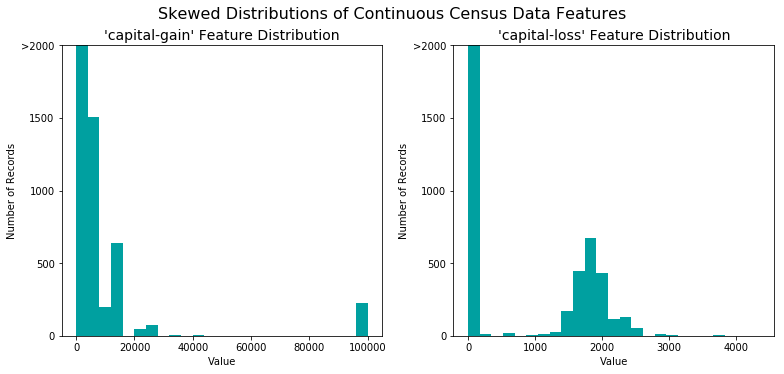

In [10]:
# Splitting the data into features and target label
income_raw = data["income"]
features_raw = data.drop("income", axis = 1)

# Visualizing skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

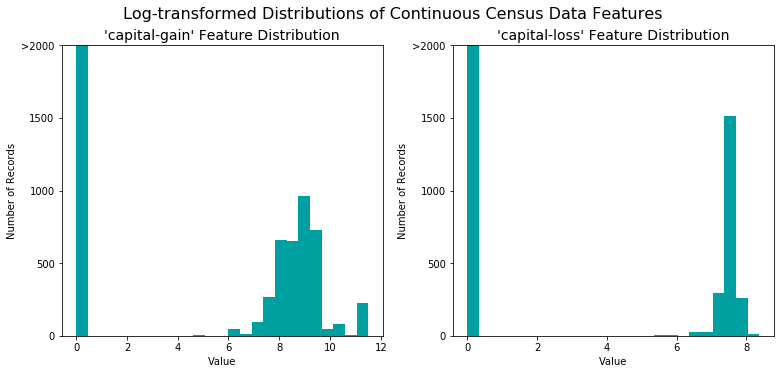

In [11]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [12]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [13]:
#Doing One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Doing Encode the 'income_raw' data for converting it to numerical values 
# and the assignment of that spletting dataset 'income_raw' to the variable income
income = income_raw.map({">50K": 1, "<=50K": 0})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)

print("{} total features after one-hot encoding.".format(len(encoded)))
# Printinge the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

[0 1]
0    34014
1    11208
Name: income, dtype: int64


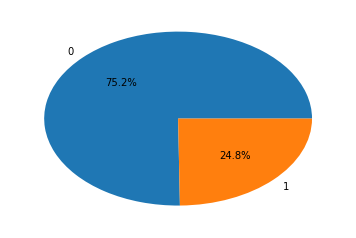

In [13]:
# showing the value of the Target Lable "income" after converting categorical values into numerical.
print(income.unique())
print(income.value_counts())
# For comparing values of pie plotting with values in previos histogram (hist(data["income"])  
income_numeric = income.value_counts()
plt.pie(income_numeric,labels = income_numeric.index,autopct='%1.1f%%');

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [14]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - 
### - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [15]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# TODO: Calculate accuracy, precision and recall
TP = np.sum(income)
FP = income.count() - TP
TN = 0
FN = 0
#  Calculateing accuracy, precision and recall
# Accuracy is the ratio of the number of correct predictions to the total number of predictions
accuracy = (TP + TN) / (TP + FP + TN + FN)
# Recall score is (True Positives/(True Positives + False Negatives))
recall = float(TP)/(TP+FN)
# Precision is (True Positives/(True Positives + False Positives))
precision = float(TP)/(TP+FP)

# Calculating F-score using the formula above for beta = 0.5 and correct values for precision and recall.
# F-beta score=(1+ beta^2)((precision*recall)/(( beta^2*Precision)+ recall))
beta = BETA
fscore = ((1+(beta**2)) * precision * recall) / (((beta**2)*precision)+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### **Answer : 1 **
| Benchmark | Accuracy score | F-score |
| :-:| :-: | :-: |
| Naive Predictor| 0.2478 | 0.2917

###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

### **Answer : 2 **
### - Model Application
<strong><u>Here are three of the supervised learning models, that are appropriate for this problem</u></strong>

#### 1) DecisionTreeClassifier
- <strong>Describtion of one real-world application in industry where the model can be applied:</strong><br>
Decision Trees are a type of Supervised Machine Learning (what the input is and what the corresponding output is in the training data) where the data is continuously split according to a certain parameter.One of the modern important real-world examples using DecisionTreeClassifier is:
<br><strong style="color: red; opacity: 0.80;"> "Water quality model to predict the cleanliness of drinking water"</strong><br>
AS presented from (MCIT)-University of Embu at 2019,"an applying study", water quality model was implemented using decision tree technique. Knowing that The analysis of water Alkalinity,pH level and conductivity can play a major role in assessing water quality.
Five decision tree classifiers (which are J48,LMT,Random forest, Hoeffding tree and DecisionStump) were used to build the model and the accuracy compared. J48 decision tree had the highest accuracy of 94% with DecisionStump having the lowest accuracy of 83%.
<br>So,The decision tree classifier provided with quality water parameters...can be used to predict whether drinking water is clean or not.
<br>https://www.eajournals.org/wp-content/uploads/A-classification-model-for-water-quality-analysis-using-decision-tree.pdf<br>
- <strong>The strengths of the model, when does it perform well include:</strong>
<br> -- Simple to understand and to interpret. Trees can be visualized.
<br> -- Requires little data preparation. 
<br> -- Able to handle multi-output problems.
<br> -- Possible to validate a model using statistical tests.
 - <strong>The weaknesses of the model, when does it perform poorly include:</strong>
<br> -- Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting.
<br> -- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated.
<br> -- Predictions of decision trees are neither smooth nor continuous, but piecewise constant approximations, they are not good at extrapolation.
<br> -- Decision tree learners create biased trees if some classes dominate. So it's recommended to balance the dataset prior to fitting with the decision tree.
<br> https://scikit-learn.org/stable/modules/tree.html <br>
- <strong>DecisionTreeClassifier considered as a good candidate for the problem given what knowing about the data, because:</strong>
<br> Decision trees are known in used to handle both continuous and categorical variables. But here,it's better to use DecisionTreeClassifier in comparisons results with other machine learning models.<u>the reason of using DecisionTreeClassifier here only as a compared model is:<br></u><font color = red> "...It turns out that sklearn's decision tree cannot handle categorical data indeed. There is a Github started issuing on this(#4899) from June 2015, ..., and continued in #12866, so the issue is still not resolved)</font> https://stackoverflow.com/questions/47873366/can-sklearn-decisiontreeclassifier-truly-work-with-categorical-data

#### 2) AdaBoostClassifier
- <strong>Describtion of one real-world application in industry where the model can be applied:</strong><br> 
AdaBoost(the Adaptive Boosting)is well-known technique in the field of medical diagnosis where it could be improved binary and multi-class classifications.A recent example is:,<br><strong style="color: red; opacity: 0.80;"> "An empowered AdaBoost algorithm implementation: A COVID-19 dataset study."</strong><br>That applied study is believed to be implemented for other real-life situations during epidemic conditions.
<br>https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8730510/
- <strong>The strengths of the model, when does it perform well include:</strong>
<br> -- AdaBoost is easy to implement.
<br> -- It iteratively corrects the mistakes of the weak classifier and improves accuracy by combining weak learners.
<br> -- AdaBoost is not prone to overfitting.
- <strong>The weaknesses of the model, when does it perform poorly include:</strong>
<br> -- AdaBoost is sensitive to noise data.
<br> -- It is highly affected by outliers because it tries to fit each point perfectly.
<br> -- AdaBoost is slower compared to XGBoost.
<br>https://www.kaggle.com/code/prashant111/adaboost-classifier-tutorial
- <strong>AdaBoostClassifier considered as a good candidate for the problem given what knowing about the data, because:</strong><br>
AdaBoost is suitable here as data in current census dataset not noisy. Also it is highly affected by the outliers, so the outliers in census dataset may cause obtimization to the model learning because AdaBoost tries to fit each point perfectly,AdaBoost can be used with many base classifiers, imagining that as a first base classifier we train a Decision Tree algorithm to make predictions on our training data...

#### 3) Support Vector Machines(SVM)
- <strong>Describtion of one real-world application in industry where the model can be applied:</strong><br>
Support-vector machines SVMs are one of the most powerful and robust classification and regression algorithms in multiple fields of application.The SVM has been playing a significant role in pattern recognition which is an extensively popular and active research area.Recently survey study foucsed on SVMs Applications: <br>
<strong style="color: red; opacity: 0.80;">A comprehensive survey on support vector machine classification: Applications, challenges and trends</strong><br>
https://www.sciencedirect.com/science/article/abs/pii/S0925231220307153
one of the popular Applied Examples for SVM Classification is:
<br><strong style="color: red; opacity: 0.80;"> Credit card dataset: SVM Classification</strong><br>
https://www.kaggle.com/code/pierra/credit-card-dataset-svm-classification
- <strong>The strengths of the model, when does it perform well include:</strong>
<br> -- SVC effective in high dimensional spaces.
<br> -- SVC uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
<br> -- SVC is versatile: different Kernel functions can be specified for the decision function.
- <strong>The weaknesses of the model, when does it perform poorly include:</strong>
<br> -- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
<br> -- SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).
<br>https://scikit-learn.org/stable/modules/svm.html
- <strong> SVM considered as a good candidate for the problem given what knowing about the data, because:</strong><br<
SVM offers very high accuracy compared to other classifiers such as logistic regression..., The predictions from the training census data needs to be more accurate as possible

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [20]:
# Importing two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score,accuracy_score

# Defining the function train_predict
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fitting the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time

    # Calculating the training time
    results['train_time'] = end-start
    # Getting the predictions on the test set(X_test),
    # then getting predictions on the first 300 training samples(X_train) using .predict()
    
    sample_train_size = 300

    ''' We assume a very niglect size of sample in this studing case to reduce the time needed, 
    as it is'nt a real ML APP '''
    
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time

    # Calculating the total prediction time
    results['pred_time'] = end-start

    # Computing accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:sample_train_size], predictions_train[:sample_train_size])

    # Computing accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)

    # Computing F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:sample_train_size], predictions_train[:sample_train_size], beta=BETA)

    # Computing F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=BETA)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

DecisionTreeClassifier trained on 36177 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 362 samples.
SVC trained on 36177 samples.
SVC trained on 3618 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 362 samples.
AdaBoostClassifier trained on 36177 samples.
AdaBoostClassifier trained on 3618 samples.
AdaBoostClassifier trained on 362 samples.


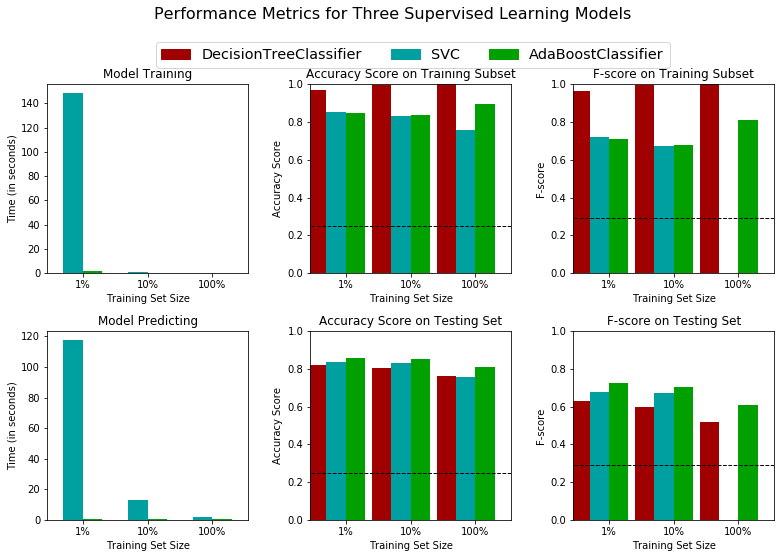

In [21]:
#  Importing the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
# Initializing the three models
clf_A = DecisionTreeClassifier(random_state=7)
clf_B = SVC(random_state = 7)
clf_C = AdaBoostClassifier(random_state = 7)

#  Calculating the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensuring to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensuring to set the count of the values to be `int` and not `float`)
samples_100 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_1 = len(X_train)

# Collecting results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [19]:
''' Printing out the values in the visualizations above 
    to examine the results in more detail'''
for result in results.items():
    print (result[0])
    display(pd.DataFrame(result[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

DecisionTreeClassifier


,1%,10%,100%
acc_test,0.817910,0.805417,0.762963
acc_train,0.970000,0.996667,1.000000
f_test,0.626563,0.601098,0.521142
f_train,0.963855,0.997191,1.000000
pred_time,0.032839,0.028033,0.020367
train_time,0.566903,0.031808,0.002968


SVC


,1%,10%,100%
acc_test,0.837148,0.832615,0.756219
acc_train,0.853333,0.833333,0.760000
f_test,0.674477,0.671256,0.000000
f_train,0.719697,0.671296,0.000000
pred_time,116.077360,13.192320,1.633964
train_time,146.240228,1.228502,0.015241


AdaBoostClassifier


,1%,10%,100%
acc_test,0.857601,0.849862,0.810282
acc_train,0.850000,0.840000,0.896667
f_test,0.724551,0.701882,0.610253
f_train,0.711538,0.680147,0.811688
pred_time,0.390692,0.371231,0.373079
train_time,2.233303,0.247331,0.084476


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

<center><strong><font color=red>Checking the F score for the testing set when 100% of the training set is used</font></strong></center>

| Benchmark: | Accuracy score | F-score |total prediction time|train_time|
|:-:|:-:|:-:|:-:|:-:|
| Naive Predictor| 0.2478 |0.2917|---|---|
|DecisionTreeClassifier|0.7629 |0.5211|0.0203|0.0029|
| SVC|0.7562|0|1.6339|0.0152|
| AdaBoostClassifier| 0.8102 |0.6102|0.3730|0.0844|

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

### **Answer : 3 **
<strong>Really, we are focusing on the model's ability to precisely predict individuals that make more than $50,000. </strong><br>that aspect is more important than the model's ability to recall those individuals. <br><font color=red>
AdaBoostClassifier is the classifier that performs best on the testing data, in terms of both the Accuracy 0.8102 0and F-score 0.6102.Also AdaBoostClassifier is takes (on the full dataset)resonably low time to train= 0.0844, and total prediction time= 0.373 </font><br>
It is clearly seen that Support Vector Machines SVM needs a higher time to give a classification result than the other two classifiers, Decision Tree and AdaBoost. Although the accuracy and the f-score of SVM and AdaBoost is nearly the same, SVM can be eliminated according to the training time.The decision between the AdaBoost and the Decision Tree should be done by looking at accuracy and f-score, since their training time is more acceptable. It is seen that AdaBoost gives the better results in accuracy and f-score on testing set. In addition, decision tree algorithm may result in overfitting. Therefore AdaBoost algorithm is chosen as the best model for the dataset.


#### Now to compleate the answer3 about why choosing Adaboost? :
Here is, <strong><font color = red> How does the AdaBoost algorithm work:</font></strong><br>
It works in the following steps:

- Initially, Adaboost selects a training subset randomly.
- It iteratively trains the AdaBoost machine learning model by selecting the training set based on the accurate prediction of the last training.
- It assigns the higher weight to wrong classified observations so that in the next iteration these observations will get the high probability for classification.
- Also, It assigns the weight to the trained classifier in each iteration according to the accuracy getting. The more accurate classifier will get high weight.
- This process iterate until the complete training data fits without any error or until reached to the specified maximum number of estimators.
- To classify, perform a "vote" across all of the learning algorithms you built.<br>
https://www.datacamp.com/tutorial/adaboost-classifier-python

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **
When explaining your model, if using external resources please include all citations.

### **Answer :4 ** 
- As an introductory summary, The ensemble methods aim to combine the predictions of several base estimators, to improve the performance of a single estimator. Two families of ensemble methods are averaging methods (which average the predictions of independently several estimators)and the boosting methods, which thier base estimators are built sequentially withThe motivation to combine several weak models to produce a powerful ensemble. AdaBoost is one of the first boosting algorithms that can be used for both classification and regression problems.The weak learners in AdaBoost are decision trees with a single split, called decision stumps. By default, Adaboost uses a decision stump as its base classifier, which can handle categorical and numerical data. Weak learners are relatively faster to train, so the dataset size is not a problem for the algorithm.

- So, How simply Adaboost works step by step:<br>

1- Adaboost works by combining several simple learners to create an ensemble of learners that can predict whether an individual earns above 50k or not.

2- Each of the learners, i.e decision trees, are created using "features" or inputs about individuals (eg. age, occupation, education, etc), It must be identify a set of rules that can predict a person's income.

3- During the training process, the Adaboost algorithm looks at instances where it has predicted badly, the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. The training iteration are repeated for a number of iterations defined by the user in an attempt to find the set of weighted hypotheses that combined will perform best on the data.

4- All the learners are then combined to make a final ensembled model, where they each vote to predict if a person earns more than 50k or not. Usually we take the majority of the votes to make a final prediction.

5- Using this model with the census information of individuals, we can predict if a person makes more than $50,000 per year or not. In this way we can use this prediction to understand if it is a good idea to contact a new potential donor beacause he will likely donate to the charity.

https://scikit-learn.org/stable/modules/ensemble.html

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [22]:
# Importing 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
# Initializing the classifier
clf = AdaBoostClassifier(random_state=7)

# Creating the parameters list you wish to tune, using a dictionary if needed.
# Dictionary Creation as follow: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators':[75,200,500],'learning_rate':[1.0,1.5,2.0]}
# TODO: Make an fbeta_score scoring object using make_scorer()
scorer =  make_scorer(fbeta_score, beta=BETA)

# Performing grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(
    estimator= clf, 
    param_grid=parameters, 
    scoring= scorer
)

# Fiting the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Making predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Reporting the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = BETA)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = BETA)))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8677
Final F-score on the testing data: 0.7452


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |                   |                 |
| F-score        |                   |   EXAMPLE       |


### **Answer :5 ** 
| Metric| Benchmark Predictor | Unoptimized Model | Optimized Model |
| :-:| :-:| :-: | :-: |
|Accuracy Score|0.2478 |0.8576|0.8677|
|F-Score|0.2917 |0.7246|0.7452|

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

### **Answer :6 **
<strong>Looking at all explored features:</strong><br>
there are thirteen available features for each individual on record in the census data.<br>
- age
- workclass 
- education_level
- education-num
- marital-status
- occupation
- relationship
- race
- sex
- capital-gain
- capital-loss
- hours-per-week
- native-country
<br><strong>Detrmention of The five featurs which are having more important relation to person income, and also having the greatest effects on prediction.: </strong>
- education: people with higher education are reasonably more likely to have an higher income.They could have more money from technical/specialized occupation jops  
- age: As people get older, they accumulate greater weatlh.Also usually, younger persons earn less money because assuming to have less experience in the position.
- hours-per-week: The more hours someone works the higher his income should be. (this directly influnces the income than the features occupation or workclass)  
- capital-gain: somone has a capital gain if he sells the asset for more than its adjusted basis.
- capital loss: capital loss if someone sells the asset for less than its adjusted basis. Losses from the sale of personal-use property, such as your home or car.
https://www.irs.gov/taxtopics/tc409#

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

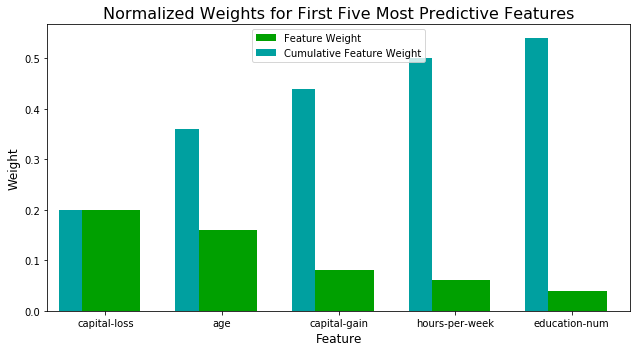

In [23]:
# Importing a supervised learning model that has 'feature_importances_'
# Training the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier().fit(X_train,y_train)

# Extracting the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Ploting
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

### **Answer :7 **
- Because of the background in business administration, the five features that were predicted in the previous section—education, age, number of hours worked per week, capital gains, and capital losses—are all included in the list of features that Adaboost considers most important, But these features are ranked in  different order.citting the source for the quoted definition of the two variables: capital gains and capital losses, from An official website of the United States Government.

- Nearly, this perception confirms the private thoughts, which were based on specialized intuitive thinking, and according to the following order: the social variable "education", then the personal variable "age", then the work environment variable "hours-per-week", then the two variables that could be classified as economic return/risk variables, those are capital-gain ,capital-loss. 

- And the difference between that arrangement of specialized human thinking, and the arrangement of the model It was in the progress of the work environment variable over the personal variable. <br><font color=red>Noting that:The five Features more importance for Adaboost are those normalized in the previos stages of this research <br>
    numerical = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"] </font> <br>
<font color=green> Where, normalization ensures that each feature is treated equally when applying supervised learners.And once scaling is applied, observing the data in its raw form will no longer have the same original meaning </font>

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [24]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8677
F-score on testing data: 0.7452

Final Model trained on reduced data
------
Accuracy on testing data: 0.8421
F-score on testing data: 0.7003


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

| Metrics|Model reduced_data| Optimized Model|
| :-:| :-:| :-: |
|Accuracy Score|0.8421|0.8677|
|F-Score|0.7003|0.7452|

### **Answer :8 **
- From above results ,It is seen that the feature selection results is decreased in accuracy and f-score.  It may be due to the decrease in complexity of data processing. The algorithm is not understand the complexity of the dataset with the 5 features and cannot make the generalization in a best way. However, the effects on the accuracy and f-score are nearly acceptable by comparing the effect of the training time. 

- Realy, choosing to make not the final model based on the most important features may be better . Training time was no factor for the AdaBoost algorithm used for the whole dataset and even with the fact,that the accuracy and F-score didn't go down so much - having an overall prediction accuracy of 83,88 % whereas the f-score with 70.71 % It is not very much worse. 

- The ratio of acccuracy lowering is 0.03107 i.e ~ 3% , while the f-score is lowering by the ratio of 0.0579 i. e ~5.8% . Even though Adaboost is relatively the fastest  one of the other classifiers that tried out, it could be consided training on the reduced data only if training time was an important factor.

- <font color= red>The decision will also depend on how important accuracy and f-scores are (or if f-score is more important than the accuracy, as its decreasing ratio is greater than decreasing ratio in accuracy). Again, If the training time is an important factor, using the reduced data as training set would be done, and the reduced accuracy will be the cost of this case.</font>

###  Recommendations (Optimaization)
<strong><font color= green>Thinking in anthor side leads to intermediat solution by increasing noumber of feature_importances_ i.e Offering a compromise that may combine all the advantages of speed and accuracy, that needs to more experimentation or training, <u>But by increasing the number of important features</u>.The number can be added 3 extra features, that increases the feature_importances number till 8 features.Also may be Normalization to this additional features needed.</font></strong><br>
<u>The features Supposed to have extra code Normalization are:</u> 
- relationship:as a social variable 
- sex: as a private variable 
- occupation: as a work-environment variable

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [26]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 557344 bytes to finding_donors.html']